In [7]:
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.metrics import classification_report
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [2]:
# Configuration & Seeding
DATA_PATH = Path("data")
TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / "test"

# Model parameters from the paper and common standards
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.001

# # Set seeds for replicability
torch.manual_seed(1)
np.random.seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
# data
# data/train/FAKE/*.jpg
# data/train/REAL/*.jpg
# data/test/FAKE/*.jpg
# data/test/REAL/*.jpg


class CIFAKEDataset(Dataset):
    def __init__(self, root_dir: str) -> None:
        self.root_dir = root_dir
        self.transform = transforms.ToTensor()
        self.image_paths = list(Path(root_dir).rglob("*.jpg"))
        self.labels = np.array([self._get_label_from_path(p) for p in self.image_paths])

    def _get_label_from_path(self, path: Path) -> int:
        return 1 if path.parent.name == "FAKE" else 0

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train_dataset = CIFAKEDataset(TRAIN_PATH)
test_dataset = CIFAKEDataset(TEST_PATH)

In [6]:
len(train_dataset), len(test_dataset)

(100000, 20000)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [8]:
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")
    break

Batch of images shape: torch.Size([128, 3, 32, 32])
Batch of labels: tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        1., 1.])


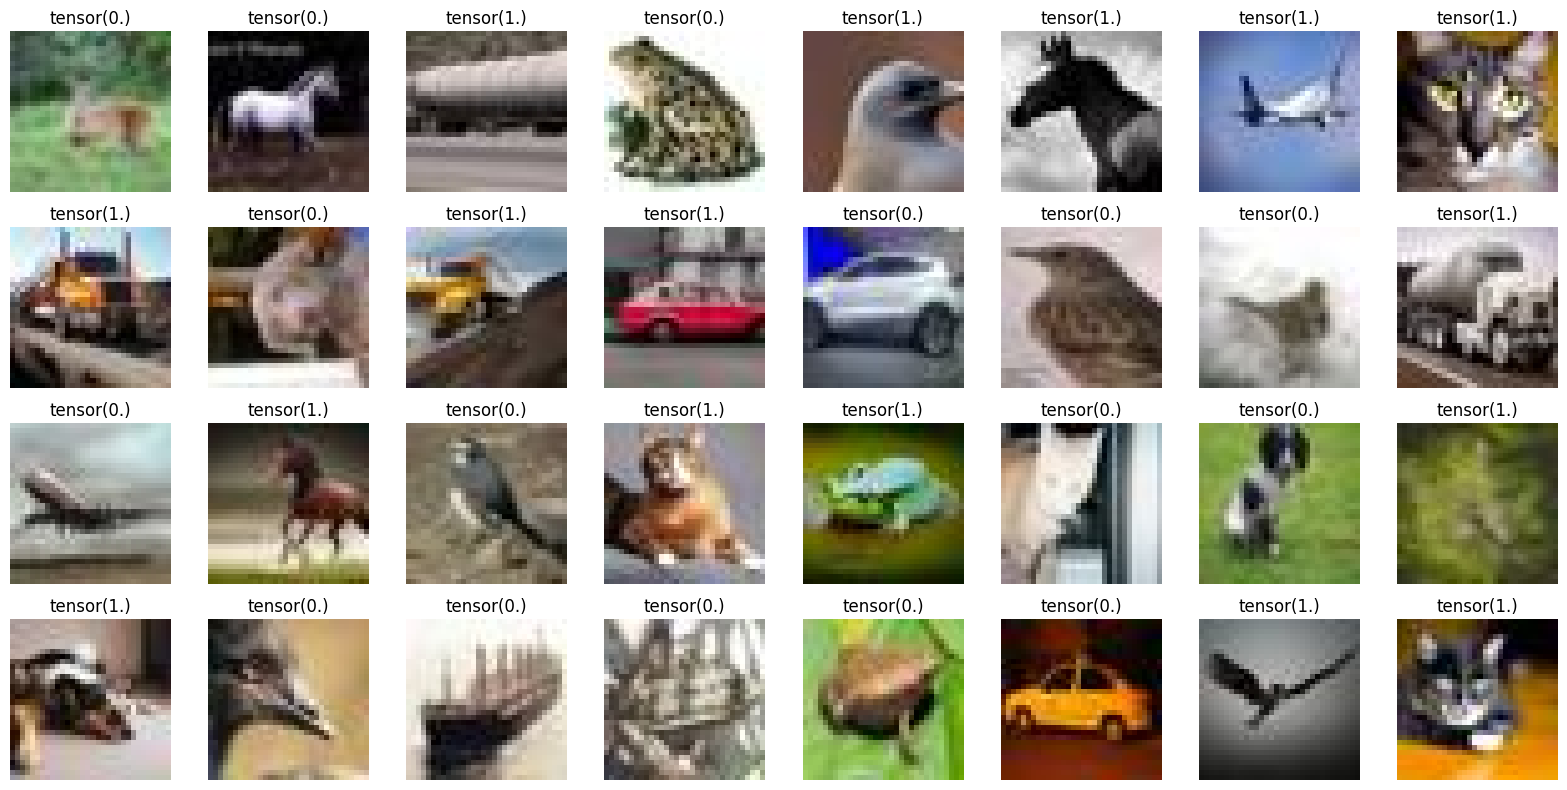

In [9]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for idx in range(min(BATCH_SIZE, 32)):
    row = idx // 8
    col = idx % 8
    ax = axes[row, col]
    img = images[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(labels[idx])
    ax.axis("off")
plt.tight_layout()
plt.show()

![Model Architecture](assets/model_arch.png)

In [10]:
# Model Definition
class CIFAKEModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Conv2D (32 x ReLu)
        # Keras default padding 'valid' (no padding)
        # 32x32 -> 30x30
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)

        # Max Pool
        # 30x30 -> 15x15
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2D (32 x ReLu)
        # 15x15 -> 13x13
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

        # Max Pool
        # 13x13 -> 6x6 (integer division)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten
        # We calculate the flattened size: 32 channels * 6 * 6
        self.flat_features = 32 * 6 * 6

        # Dense (64 x ReLu)
        self.fc1 = nn.Linear(in_features=self.flat_features, out_features=64)

        # Dense (Sigmoid)
        self.output = nn.Linear(in_features=64, out_features=1)

        # Activation functions
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Flatten
        x = torch.flatten(x, 1)  # Flatten all dims except batch

        # Dense layers
        x = self.fc1(x)
        x = self.relu(x)

        # Output
        return self.output(x).squeeze(1)


# Instantiate model and move to device
model = CIFAKEModel().to(device)

# Print a summary (manual, as torch.summary is not built-in)
print("\nModel Architecture:")
print(model)


Model Architecture:
CIFAKEModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [5]:
# More complex model definition
class CIFAKEModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten
        self.flat_features = 128 * 4 * 4  # Assuming input size 32x32

        # Dense layers
        self.fc1 = nn.Linear(self.flat_features, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.output(x).squeeze(1)


# Instantiate the more complex model and move to device
model_v2 = CIFAKEModelV2().to(device)
print("\nModel V2 Architecture:")
print(model_v2)



Model V2 Architecture:
CIFAKEModelV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, ou

In [12]:
def train_model(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    num_epochs: int,
    device: torch.device,
) -> dict[str, list[float]]:
    # model.train() can be outside the epoch loop if no validation is done
    # but inside the loop is more flexible for future changes like adding validation
    # where model.eval() is needed before validation to set dropout/batchnorm layers to eval mode

    # Pytorch does not have built-in history tracking
    train_loss_history = []
    train_report_history = []
    val_loss_history = []
    val_report_history = []
    train_time_history = []
    val_time_history = []
    best_model = None

    for epoch in range(num_epochs):
        # best practice to set model to training mode at the start of each epoch
        model.train()

        # Running loss for the epoch, reset at each epoch
        # The reason why we use running loss instead of just loss is that
        # loss.item() gives the loss for the current batch only.
        # To get the average loss over the entire epoch, we accumulate it.
        # This is especially useful when the dataset size is not perfectly divisible by the batch size.
        # It ensures that we account for all batches, including the last one which might be smaller.
        # We update weights after each batch, that means the loss is computed per batch,
        # then backpropagated, and weights are updated.
        # And then loss is calculated for the next batch with the updated weights, and so on.
        running_train_loss = 0.0

        train_predictions = []
        train_true_labels = []
        train_time_start = time.time()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
            # Put data on the correct device, both X and y
            images, labels = images.to(device), labels.to(device)

            # zero_grad() clears old gradients from the last step
            # so that forward pass can create a new backpropagation directed graph
            # that does not mix up gradients between batches.
            optimizer.zero_grad()

            # Forward pass to get predictions and generate backpropagation directed graph
            outputs = model(images)

            # Calculate loss of current batch
            loss = criterion(outputs, labels)

            # Calculate gradients of by traversing back the graph
            # and store them in the grad attributes of the parameters
            loss.backward()

            # Update model parameters using the calculated gradients
            # This is where "new_weights = old_weights - learning_rate * gradients" happens
            optimizer.step()

            # Accumulate running loss of each batch
            # loss.item() gets the scalar value of the loss tensor
            # This is used to compute average loss over the batches in the epoch
            running_train_loss += loss.item()

            # For binary classification with sigmoid output
            predictions = (outputs > 0.5).float()
            train_predictions.extend(predictions.cpu().numpy().flatten())
            train_true_labels.extend(labels.cpu().numpy().flatten())
        train_time_end = time.time()
        train_time_history.append(train_time_end - train_time_start)
        # Calculate average loss over the epoch
        avg_loss_over_epoch = running_train_loss / len(train_loader)

        # Append average loss to history for later plotting
        train_loss_history.append(avg_loss_over_epoch)
        train_report = classification_report(
            train_true_labels,
            train_predictions,
            output_dict=True,
            digits=4,
            zero_division=0,
        )
        train_report_history.append(train_report)

        # Validation phase
        running_val_loss = 0.0
        val_predictions = []
        val_true_labels = []

        model.eval()  # Set model to evaluation mode before validation
        val_time_start = time.time()
        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)

                # Forward pass without tracking gradients
                outputs = model(images)

                # Calculate validation loss of current batch
                val_loss = criterion(outputs, labels)

                # Accumulate running validation loss
                running_val_loss += val_loss.item()

                # Store predictions and true labels for accuracy and F1 score calculation
                predictions = (outputs > 0.5).float()
                val_predictions.extend(predictions.cpu().numpy().flatten())
                val_true_labels.extend(labels.cpu().numpy().flatten())
        val_time_end = time.time()
        val_time_history.append(val_time_end - val_time_start)

        # Calculate average validation loss, accuracy, f1 over the epoch
        avg_val_loss_over_epoch = running_val_loss / len(val_loader)

        val_loss_history.append(avg_val_loss_over_epoch)

        val_report = classification_report(
            val_true_labels,
            val_predictions,
            output_dict=True,
            digits=4,
            zero_division=0,
        )
        val_report_history.append(val_report)

        if best_model is None or val_report["accuracy"] > best_model["accuracy"]:
            best_model = {
                "state_dict": model.state_dict(),
                "accuracy": val_report["accuracy"],
            }
        # Print epoch loss for monitoring
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] | "
            f"Train Loss: {avg_loss_over_epoch:.4f} | "
            f"Train Acc: {train_report['accuracy']:.4f}, Train F1: {train_report['macro avg']['f1-score']:.4f} | "
            f"Val Loss: {avg_val_loss_over_epoch:.4f} | ",
            f"Val Acc: {val_report['accuracy']:.4f}, Val F1: {val_report['macro avg']['f1-score']:.4f} | ",
            f"Train Time: {train_time_history[-1]:.2f}s, Val Time: {val_time_history[-1]:.2f}s",
        )

    return {
        "best_model": best_model,
        "train_loss_history": train_loss_history,
        "train_report_history": train_report_history,
        "val_loss_history": val_loss_history,
        "val_report_history": val_report_history,
        "train_time_history": train_time_history,
        "val_time_history": val_time_history,
    }

In [13]:
model = CIFAKEModel().to(device)
train_result = train_model(
    train_loader,
    test_loader,
    model,
    nn.BCEWithLogitsLoss(),
    optim.Adam(model.parameters(), lr=LEARNING_RATE),
    EPOCHS,
    device,
)

Epoch 1/20 - Validation: 100%|██████████| 157/157 [00:16<00:00,  9.69it/s]


Epoch [1/20] | Train Loss: 0.3869 | Train Acc: 0.8063, Train F1: 0.8043 | Val Loss: 0.3453 |  Val Acc: 0.8140, Val F1: 0.8090 |  Train Time: 76.48s, Val Time: 16.21s


Epoch 2/20 - Validation: 100%|██████████| 157/157 [00:15<00:00, 10.28it/s]


Epoch [2/20] | Train Loss: 0.2655 | Train Acc: 0.8852, Train F1: 0.8850 | Val Loss: 0.2567 |  Val Acc: 0.9048, Val F1: 0.9047 |  Train Time: 90.63s, Val Time: 15.28s


Epoch 3/20 - Validation: 100%|██████████| 157/157 [00:06<00:00, 22.54it/s]


Epoch [3/20] | Train Loss: 0.2297 | Train Acc: 0.9020, Train F1: 0.9019 | Val Loss: 0.2151 |  Val Acc: 0.8998, Val F1: 0.8994 |  Train Time: 78.51s, Val Time: 6.97s


Epoch 4/20 - Validation: 100%|██████████| 157/157 [00:13<00:00, 11.87it/s]


Epoch [4/20] | Train Loss: 0.2074 | Train Acc: 0.9135, Train F1: 0.9134 | Val Loss: 0.2651 |  Val Acc: 0.8691, Val F1: 0.8675 |  Train Time: 71.75s, Val Time: 13.23s


Epoch 5/20 - Validation: 100%|██████████| 157/157 [00:08<00:00, 19.29it/s]


Epoch [5/20] | Train Loss: 0.1944 | Train Acc: 0.9191, Train F1: 0.9191 | Val Loss: 0.2445 |  Val Acc: 0.9153, Val F1: 0.9152 |  Train Time: 81.72s, Val Time: 8.14s


Epoch 6/20 - Validation: 100%|██████████| 157/157 [00:13<00:00, 11.77it/s]


Epoch [6/20] | Train Loss: 0.1835 | Train Acc: 0.9242, Train F1: 0.9241 | Val Loss: 0.1877 |  Val Acc: 0.9121, Val F1: 0.9118 |  Train Time: 66.16s, Val Time: 13.34s


Epoch 7/20 - Validation: 100%|██████████| 157/157 [00:10<00:00, 14.39it/s]


Epoch [7/20] | Train Loss: 0.1768 | Train Acc: 0.9274, Train F1: 0.9274 | Val Loss: 0.1813 |  Val Acc: 0.9275, Val F1: 0.9275 |  Train Time: 64.91s, Val Time: 10.91s


Epoch 8/20 - Validation: 100%|██████████| 157/157 [00:15<00:00, 10.32it/s]


Epoch [8/20] | Train Loss: 0.1686 | Train Acc: 0.9305, Train F1: 0.9304 | Val Loss: 0.1735 |  Val Acc: 0.9322, Val F1: 0.9321 |  Train Time: 85.31s, Val Time: 15.22s


Epoch 9/20 - Validation: 100%|██████████| 157/157 [00:16<00:00,  9.53it/s]


Epoch [9/20] | Train Loss: 0.1629 | Train Acc: 0.9337, Train F1: 0.9337 | Val Loss: 0.1680 |  Val Acc: 0.9306, Val F1: 0.9306 |  Train Time: 90.23s, Val Time: 16.47s


Epoch 10/20 - Validation: 100%|██████████| 157/157 [00:14<00:00, 10.99it/s]


Epoch [10/20] | Train Loss: 0.1551 | Train Acc: 0.9369, Train F1: 0.9368 | Val Loss: 0.2080 |  Val Acc: 0.9029, Val F1: 0.9023 |  Train Time: 58.88s, Val Time: 14.29s


Epoch 11/20 - Validation: 100%|██████████| 157/157 [00:15<00:00,  9.90it/s]


Epoch [11/20] | Train Loss: 0.1528 | Train Acc: 0.9373, Train F1: 0.9373 | Val Loss: 0.1829 |  Val Acc: 0.9338, Val F1: 0.9338 |  Train Time: 85.59s, Val Time: 15.87s


Epoch 12/20 - Validation: 100%|██████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch [12/20] | Train Loss: 0.1455 | Train Acc: 0.9409, Train F1: 0.9409 | Val Loss: 0.1918 |  Val Acc: 0.9336, Val F1: 0.9336 |  Train Time: 84.06s, Val Time: 13.86s


Epoch 13/20 - Validation: 100%|██████████| 157/157 [00:15<00:00,  9.81it/s]


Epoch [13/20] | Train Loss: 0.1423 | Train Acc: 0.9425, Train F1: 0.9425 | Val Loss: 0.1881 |  Val Acc: 0.9340, Val F1: 0.9340 |  Train Time: 82.01s, Val Time: 16.00s


Epoch 14/20 - Validation: 100%|██████████| 157/157 [00:12<00:00, 12.71it/s]


Epoch [14/20] | Train Loss: 0.1399 | Train Acc: 0.9434, Train F1: 0.9434 | Val Loss: 0.1699 |  Val Acc: 0.9357, Val F1: 0.9357 |  Train Time: 66.53s, Val Time: 12.36s


Epoch 15/20 - Validation: 100%|██████████| 157/157 [00:15<00:00,  9.94it/s]


Epoch [15/20] | Train Loss: 0.1339 | Train Acc: 0.9452, Train F1: 0.9452 | Val Loss: 0.1647 |  Val Acc: 0.9380, Val F1: 0.9380 |  Train Time: 86.73s, Val Time: 15.79s


Epoch 16/20 - Validation: 100%|██████████| 157/157 [00:11<00:00, 14.10it/s]


Epoch [16/20] | Train Loss: 0.1318 | Train Acc: 0.9463, Train F1: 0.9463 | Val Loss: 0.1923 |  Val Acc: 0.9126, Val F1: 0.9122 |  Train Time: 90.43s, Val Time: 11.14s


Epoch 17/20 - Validation: 100%|██████████| 157/157 [00:11<00:00, 13.52it/s]


Epoch [17/20] | Train Loss: 0.1268 | Train Acc: 0.9488, Train F1: 0.9488 | Val Loss: 0.1892 |  Val Acc: 0.9141, Val F1: 0.9137 |  Train Time: 72.23s, Val Time: 11.61s


Epoch 18/20 - Validation: 100%|██████████| 157/157 [00:14<00:00, 10.71it/s]


Epoch [18/20] | Train Loss: 0.1258 | Train Acc: 0.9489, Train F1: 0.9489 | Val Loss: 0.1713 |  Val Acc: 0.9346, Val F1: 0.9346 |  Train Time: 72.12s, Val Time: 14.66s


Epoch 19/20 - Validation: 100%|██████████| 157/157 [00:24<00:00,  6.45it/s]


Epoch [19/20] | Train Loss: 0.1229 | Train Acc: 0.9509, Train F1: 0.9509 | Val Loss: 0.1892 |  Val Acc: 0.9201, Val F1: 0.9198 |  Train Time: 84.56s, Val Time: 24.35s


Epoch 20/20 - Validation: 100%|██████████| 157/157 [00:13<00:00, 11.95it/s]

Epoch [20/20] | Train Loss: 0.1180 | Train Acc: 0.9525, Train F1: 0.9525 | Val Loss: 0.2670 |  Val Acc: 0.8876, Val F1: 0.8865 |  Train Time: 67.76s, Val Time: 13.14s


In [14]:
import joblib

joblib.dump(train_result, "outputs/models_deep/train_result.joblib", compress=3)

['outputs/models_deep/train_result.joblib']

In [16]:
model2 = CIFAKEModelV2().to(device)
train_result2 = train_model(
    train_loader,
    test_loader,
    model2,
    nn.BCEWithLogitsLoss(),
    optim.Adam(model2.parameters(), lr=LEARNING_RATE),
    EPOCHS,
    device,
)

Epoch 1/20 - Validation: 100%|██████████| 157/157 [00:19<00:00,  8.08it/s]


Epoch [1/20] | Train Loss: 0.2593 | Train Acc: 0.8881, Train F1: 0.8880 | Val Loss: 0.2567 |  Val Acc: 0.8778, Val F1: 0.8762 |  Train Time: 110.32s, Val Time: 19.44s


Epoch 2/20 - Validation: 100%|██████████| 157/157 [00:13<00:00, 11.83it/s]


Epoch [2/20] | Train Loss: 0.1786 | Train Acc: 0.9291, Train F1: 0.9291 | Val Loss: 0.1868 |  Val Acc: 0.9275, Val F1: 0.9275 |  Train Time: 85.32s, Val Time: 13.27s


Epoch 3/20 - Validation: 100%|██████████| 157/157 [00:12<00:00, 12.13it/s]


Epoch [3/20] | Train Loss: 0.1539 | Train Acc: 0.9385, Train F1: 0.9385 | Val Loss: 0.1987 |  Val Acc: 0.8988, Val F1: 0.8981 |  Train Time: 59.97s, Val Time: 12.94s


Epoch 4/20 - Validation: 100%|██████████| 157/157 [00:18<00:00,  8.30it/s]


Epoch [4/20] | Train Loss: 0.1395 | Train Acc: 0.9445, Train F1: 0.9444 | Val Loss: 0.2825 |  Val Acc: 0.9051, Val F1: 0.9045 |  Train Time: 82.93s, Val Time: 18.92s


Epoch 5/20 - Validation: 100%|██████████| 157/157 [00:15<00:00, 10.38it/s]


Epoch [5/20] | Train Loss: 0.1257 | Train Acc: 0.9496, Train F1: 0.9496 | Val Loss: 0.1678 |  Val Acc: 0.9413, Val F1: 0.9412 |  Train Time: 91.44s, Val Time: 15.13s


Epoch 6/20 - Validation: 100%|██████████| 157/157 [00:14<00:00, 10.68it/s]


Epoch [6/20] | Train Loss: 0.1164 | Train Acc: 0.9542, Train F1: 0.9542 | Val Loss: 0.1366 |  Val Acc: 0.9505, Val F1: 0.9504 |  Train Time: 85.35s, Val Time: 14.70s


Epoch 7/20 - Validation: 100%|██████████| 157/157 [00:06<00:00, 22.82it/s]


Epoch [7/20] | Train Loss: 0.1077 | Train Acc: 0.9571, Train F1: 0.9571 | Val Loss: 0.1306 |  Val Acc: 0.9433, Val F1: 0.9432 |  Train Time: 68.60s, Val Time: 6.88s


Epoch 8/20 - Validation: 100%|██████████| 157/157 [00:14<00:00, 10.55it/s]


Epoch [8/20] | Train Loss: 0.0983 | Train Acc: 0.9613, Train F1: 0.9613 | Val Loss: 0.1484 |  Val Acc: 0.9224, Val F1: 0.9220 |  Train Time: 85.91s, Val Time: 14.88s


Epoch 9/20 - Validation: 100%|██████████| 157/157 [00:15<00:00, 10.08it/s]


Epoch [9/20] | Train Loss: 0.0920 | Train Acc: 0.9634, Train F1: 0.9634 | Val Loss: 0.2426 |  Val Acc: 0.8681, Val F1: 0.8659 |  Train Time: 94.01s, Val Time: 15.58s


Epoch 10/20 - Validation: 100%|██████████| 157/157 [00:15<00:00,  9.99it/s]


Epoch [10/20] | Train Loss: 0.0855 | Train Acc: 0.9666, Train F1: 0.9666 | Val Loss: 0.1222 |  Val Acc: 0.9518, Val F1: 0.9518 |  Train Time: 95.18s, Val Time: 15.71s


Epoch 11/20 - Validation: 100%|██████████| 157/157 [00:14<00:00, 11.05it/s]


Epoch [11/20] | Train Loss: 0.0782 | Train Acc: 0.9695, Train F1: 0.9695 | Val Loss: 0.1470 |  Val Acc: 0.9305, Val F1: 0.9303 |  Train Time: 93.17s, Val Time: 14.21s


Epoch 12/20 - Validation: 100%|██████████| 157/157 [00:15<00:00, 10.12it/s]


Epoch [12/20] | Train Loss: 0.0724 | Train Acc: 0.9717, Train F1: 0.9717 | Val Loss: 0.1085 |  Val Acc: 0.9570, Val F1: 0.9570 |  Train Time: 92.95s, Val Time: 15.52s


Epoch 13/20 - Validation: 100%|██████████| 157/157 [00:15<00:00, 10.04it/s]


Epoch [13/20] | Train Loss: 0.0662 | Train Acc: 0.9734, Train F1: 0.9734 | Val Loss: 0.1256 |  Val Acc: 0.9427, Val F1: 0.9426 |  Train Time: 102.22s, Val Time: 15.64s


Epoch 14/20 - Validation: 100%|██████████| 157/157 [00:14<00:00, 11.05it/s]


Epoch [14/20] | Train Loss: 0.0605 | Train Acc: 0.9764, Train F1: 0.9764 | Val Loss: 0.1137 |  Val Acc: 0.9569, Val F1: 0.9569 |  Train Time: 96.85s, Val Time: 14.21s


Epoch 15/20 - Validation: 100%|██████████| 157/157 [00:15<00:00,  9.89it/s]


Epoch [15/20] | Train Loss: 0.0575 | Train Acc: 0.9774, Train F1: 0.9774 | Val Loss: 0.1158 |  Val Acc: 0.9578, Val F1: 0.9578 |  Train Time: 99.32s, Val Time: 15.88s


Epoch 16/20 - Validation: 100%|██████████| 157/157 [00:12<00:00, 12.24it/s]


Epoch [16/20] | Train Loss: 0.0506 | Train Acc: 0.9797, Train F1: 0.9797 | Val Loss: 0.1165 |  Val Acc: 0.9512, Val F1: 0.9512 |  Train Time: 82.12s, Val Time: 12.83s


Epoch 17/20 - Validation: 100%|██████████| 157/157 [00:15<00:00, 10.28it/s]


Epoch [17/20] | Train Loss: 0.0488 | Train Acc: 0.9804, Train F1: 0.9804 | Val Loss: 0.1097 |  Val Acc: 0.9603, Val F1: 0.9602 |  Train Time: 80.61s, Val Time: 15.28s


Epoch 18/20 - Validation: 100%|██████████| 157/157 [00:11<00:00, 13.48it/s]


Epoch [18/20] | Train Loss: 0.0448 | Train Acc: 0.9821, Train F1: 0.9821 | Val Loss: 0.1283 |  Val Acc: 0.9586, Val F1: 0.9585 |  Train Time: 85.15s, Val Time: 11.65s


Epoch 19/20 - Validation: 100%|██████████| 157/157 [00:12<00:00, 12.55it/s]


Epoch [19/20] | Train Loss: 0.0404 | Train Acc: 0.9844, Train F1: 0.9844 | Val Loss: 0.1391 |  Val Acc: 0.9486, Val F1: 0.9485 |  Train Time: 75.24s, Val Time: 12.51s


Epoch 20/20 - Validation: 100%|██████████| 157/157 [00:14<00:00, 10.93it/s]

Epoch [20/20] | Train Loss: 0.0382 | Train Acc: 0.9847, Train F1: 0.9847 | Val Loss: 0.1581 |  Val Acc: 0.9512, Val F1: 0.9511 |  Train Time: 90.86s, Val Time: 14.37s


In [17]:
joblib.dump(train_result2, "outputs/models_deep/train_result2.joblib", compress=3)

['outputs/models_deep/train_result2.joblib']

In [18]:
train_result

{'best_model': {'state_dict': OrderedDict([('conv1.weight',
                tensor([[[[ 1.2110e-01, -1.8712e-01,  8.0203e-04],
                          [-1.5581e-03,  7.1943e-02, -9.4318e-02],
                          [-1.7883e-01,  1.1987e-01,  1.4519e-01]],
                
                         [[-1.3032e-01, -1.4984e-01,  3.9628e-02],
                          [-1.0507e-01, -5.1888e-02,  7.4560e-02],
                          [-1.6170e-02, -1.5830e-02, -1.4733e-01]],
                
                         [[-8.6667e-02, -2.8967e-02, -1.5823e-01],
                          [ 5.2267e-02,  1.4728e-01, -1.1239e-01],
                          [ 1.6850e-01, -8.0245e-02, -4.0902e-03]]],
                
                
                        [[[-8.1167e-03, -1.0685e-01,  1.0800e-01],
                          [ 1.0843e-01,  9.9424e-02,  3.1642e-02],
                          [-5.4298e-02,  1.0984e-02, -4.0049e-02]],
                
                         [[ 6.4005e-02,  4.784

In [22]:
train_result2["best_model"]["accuracy"]

0.96025

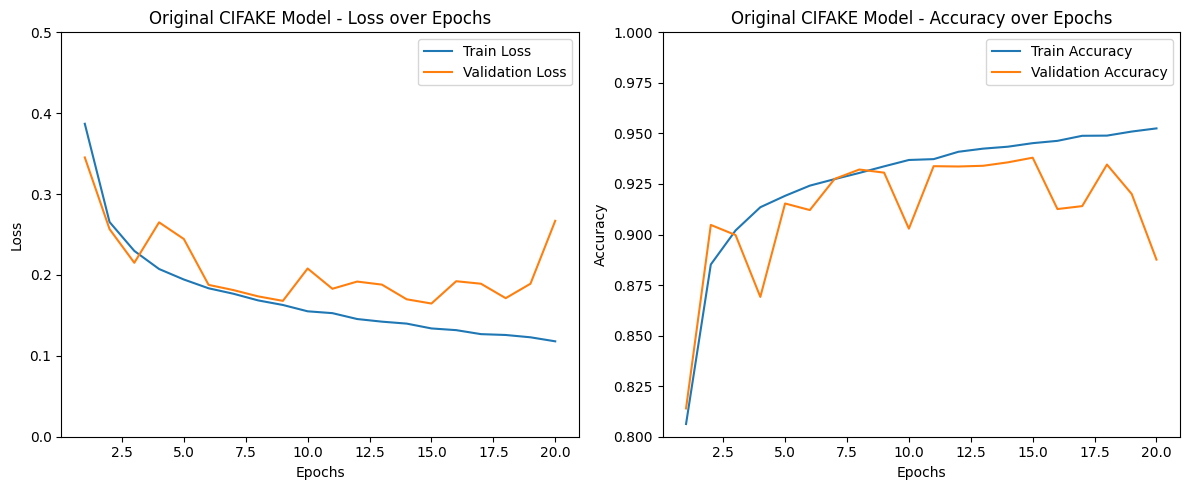

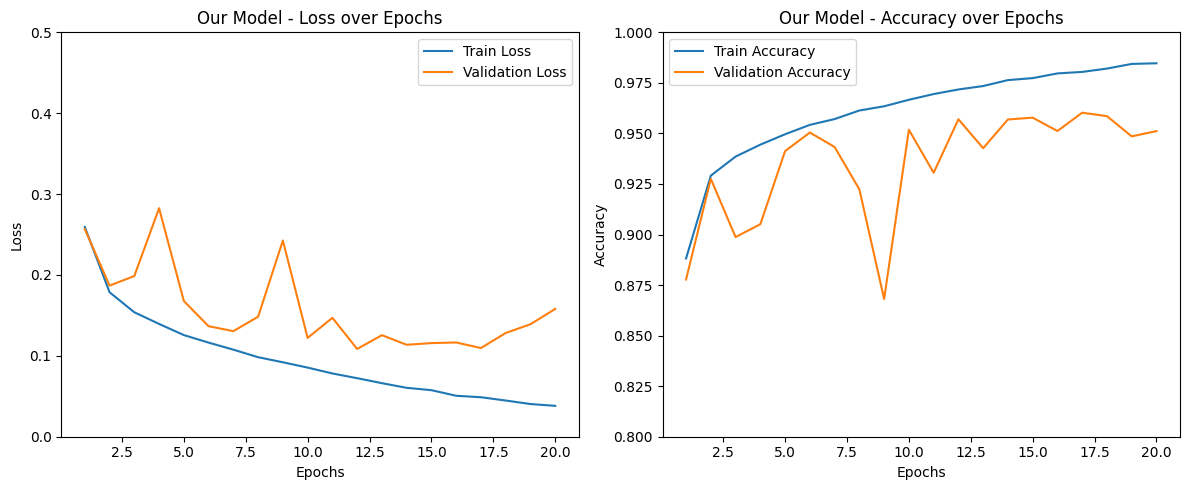

In [36]:
def plot_training_history(train_result: dict[str, list[float]], title: str) -> None:
    epochs = range(1, len(train_result["train_loss_history"]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_result["train_loss_history"], label="Train Loss")
    plt.plot(epochs, train_result["val_loss_history"], label="Validation Loss")
    plt.title(f"{title} - Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0, 0.5)
    plt.legend()

    # Plot Accuracy
    train_accuracies = [report["accuracy"] for report in train_result["train_report_history"]]
    val_accuracies = [report["accuracy"] for report in train_result["val_report_history"]]

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title(f"{title} - Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0.8, 1.0)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_training_history(train_result, "Original CIFAKE Model")
plot_training_history(train_result2, "Our Model")

In [9]:
import joblib

loaded_model = CIFAKEModelV2().to(device)
train_result2 = joblib.load("outputs/models_deep/train_result2.joblib")
loaded_model.load_state_dict(train_result2["best_model"]["state_dict"])

<All keys matched successfully>

In [24]:
# data
# data/train/FAKE/*.jpg
# data/train/REAL/*.jpg
# data/test/FAKE/*.jpg
# data/test/REAL/*.jpg


class CIFAKEDatasetNew(Dataset):
    def __init__(self, root_dir: str) -> None:
        self.root_dir = root_dir
        self.transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
        self.image_paths = list(Path(root_dir).rglob("*.jpg")) + list(Path(root_dir).rglob("*.jpeg"))
        self.labels = np.array([self._get_label_from_path(p) for p in self.image_paths])

    def _get_label_from_path(self, path: Path) -> int:
        return 1 if path.parent.name == "FAKE" else 0

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure RGB format
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

In [37]:
new_data_path = Path("data/new_images")
new_dataset = CIFAKEDatasetNew(new_data_path)
new_loader = DataLoader(new_dataset, batch_size=1, shuffle=False, pin_memory=True)
print(f"Total images in dataset: {len(new_dataset)}")
print(f"Image paths: {new_dataset.image_paths}")

Total images in dataset: 10
Image paths: [WindowsPath('data/new_images/REAL/image_1_real.jpg'), WindowsPath('data/new_images/REAL/image_2_real.jpg'), WindowsPath('data/new_images/REAL/image_3_real.jpg'), WindowsPath('data/new_images/REAL/image_4_real.jpg'), WindowsPath('data/new_images/REAL/image_5_real.jpg'), WindowsPath('data/new_images/FAKE/image_1_ai.jpeg'), WindowsPath('data/new_images/FAKE/image_2_ai.jpeg'), WindowsPath('data/new_images/FAKE/image_3_ai.jpeg'), WindowsPath('data/new_images/FAKE/image_4_ai.jpeg'), WindowsPath('data/new_images/FAKE/image_5_ai.jpeg')]


In [38]:
len(new_loader)

10

In [39]:
loaded_model.eval()
new_predictions = []
new_labels = []
for images, labels in new_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = loaded_model(images)
        predictions = (outputs > 0.5).float()
    new_predictions.extend(predictions.cpu().numpy())
    new_labels.extend(labels.cpu().numpy())

print(
    classification_report(
        new_labels,
        new_predictions,
        digits=4,
        zero_division=0,
    ),
)

              precision    recall  f1-score   support

         0.0     0.5000    0.8000    0.6154         5
         1.0     0.5000    0.2000    0.2857         5

    accuracy                         0.5000        10
   macro avg     0.5000    0.5000    0.4505        10
weighted avg     0.5000    0.5000    0.4505        10



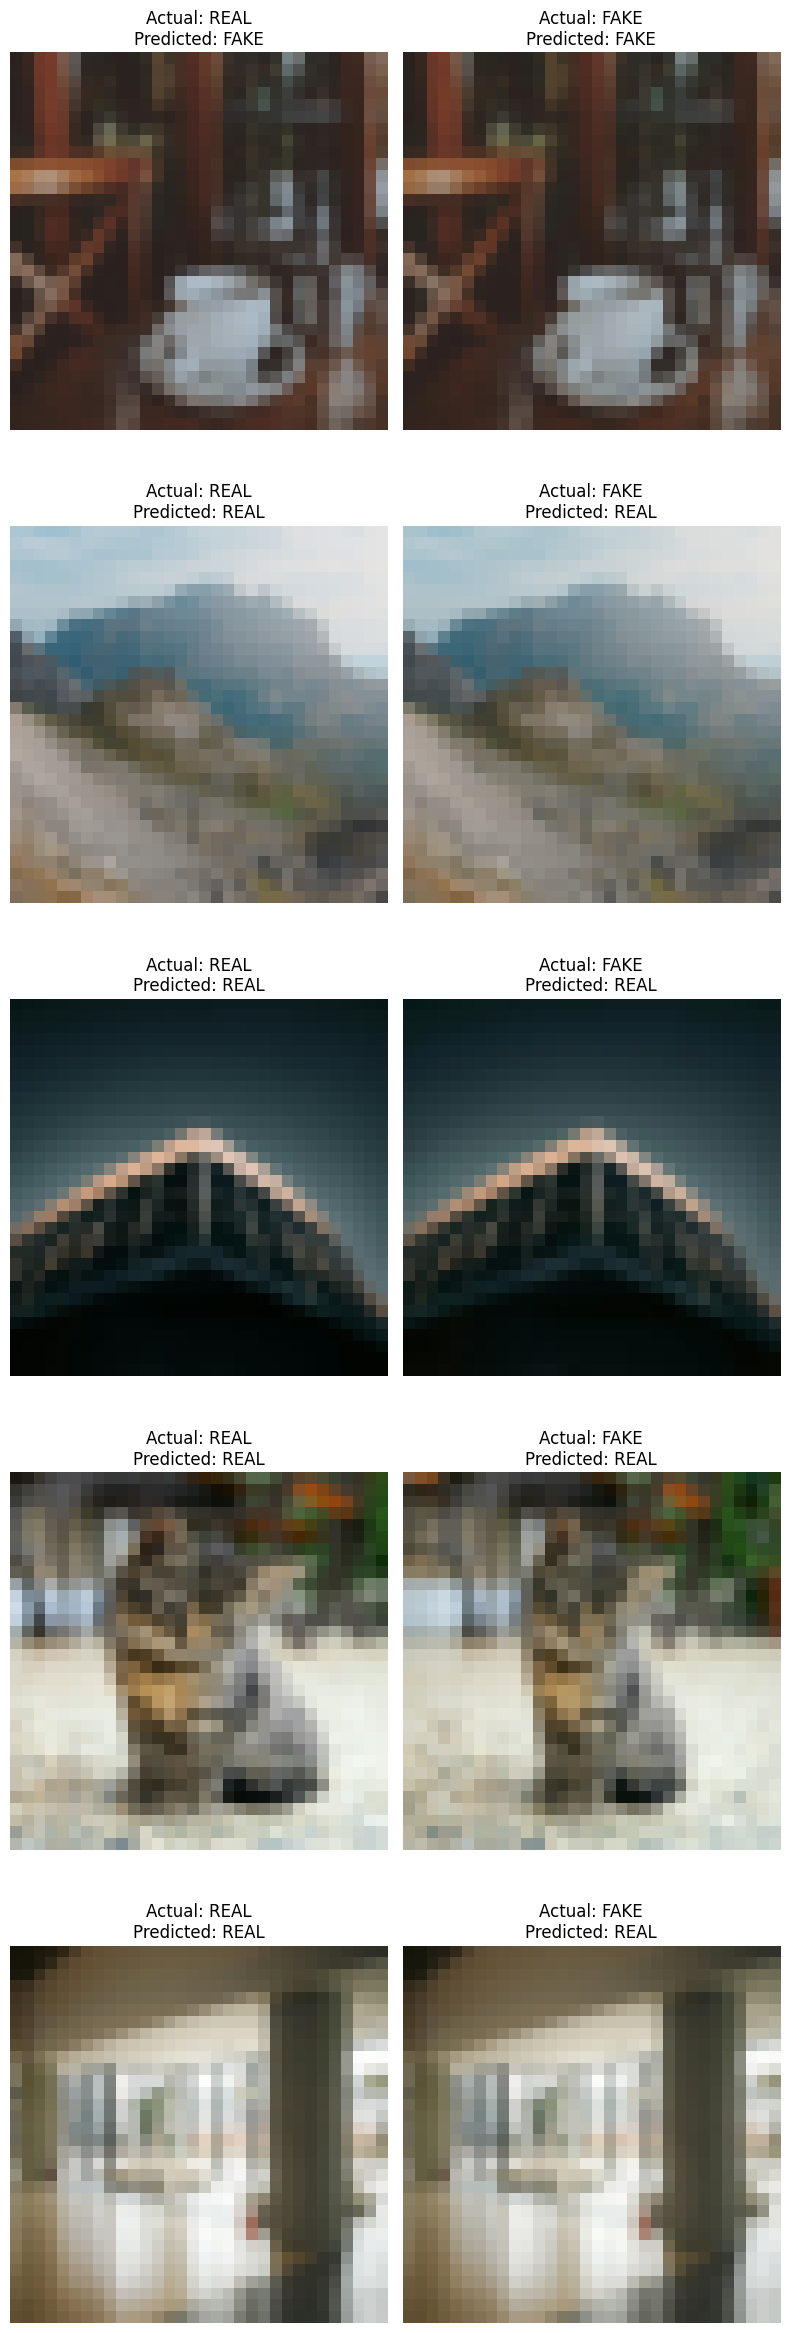

In [44]:
# Plot selected new images with actual and predicted labels
fig, axes = plt.subplots(5, 2, figsize=(8, 24))
selected_indices = [(0, 5), (1, 6), (2, 7), (3, 8), (4, 9)]

for i, (idx1, idx2) in enumerate(selected_indices):
    for j, idx in enumerate([idx1, idx2]):
        ax = axes[i, j]
        img, label = new_dataset[idx]
        img_np = img.permute(1, 2, 0).numpy()
        ax.imshow(img_np)
        actual_label = "FAKE" if label.item() == 1 else "REAL"
        with torch.no_grad():
            output = loaded_model(img.unsqueeze(0).to(device))
            prediction = (output > 0.5).float().item()
        predicted_label = "FAKE" if prediction == 1 else "REAL"
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis("off")

plt.tight_layout()
plt.show()

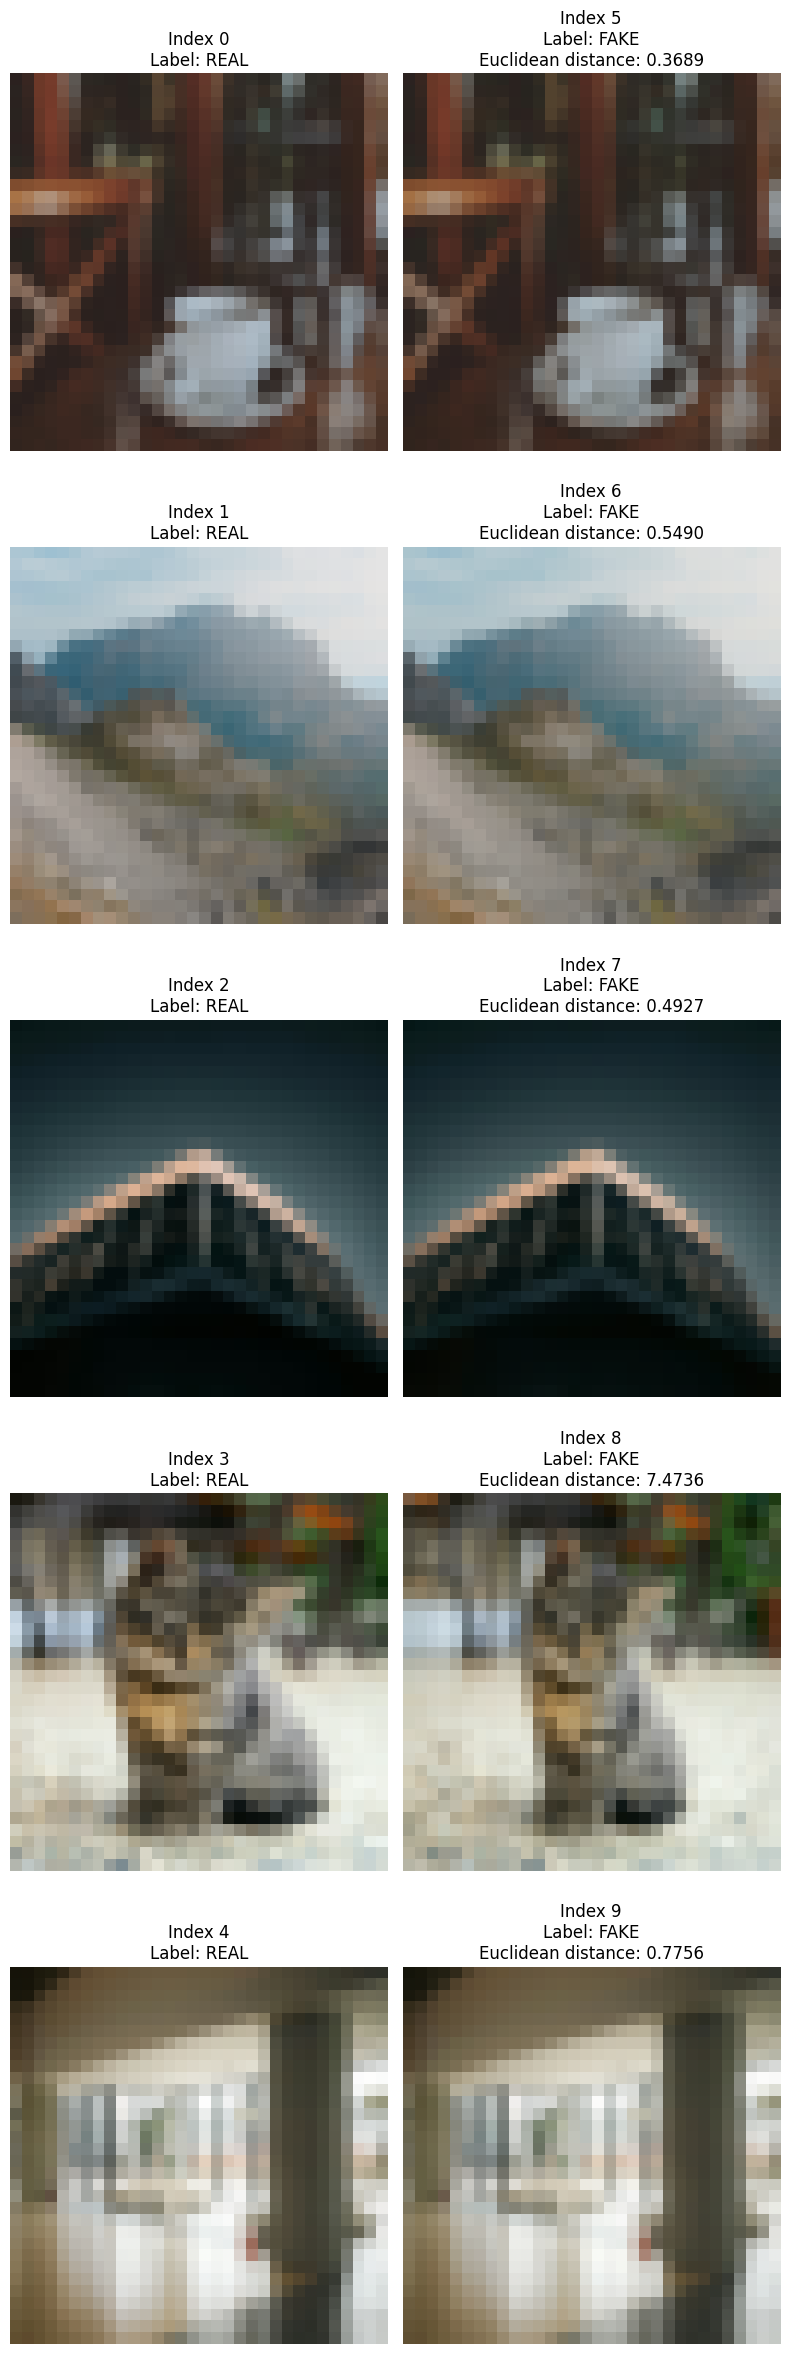

In [49]:
# Plot selected new images with actual labels and Euclidean distance
fig, axes = plt.subplots(5, 2, figsize=(8, 24))

# Each tuple (idx1, idx2) selects an image pair
selected_indices = [(0, 5), (1, 6), (2, 7), (3, 8), (4, 9)]

for i, (idx1, idx2) in enumerate(selected_indices):
    # Load paired images
    img1, label1 = new_dataset[idx1]
    img2, label2 = new_dataset[idx2]

    # Convert to NumPy arrays with shape (H, W, 3)
    img1_np = img1.permute(1, 2, 0).numpy()
    img2_np = img2.permute(1, 2, 0).numpy()

    # Compute Euclidean distance
    # Flatten both images to vectors of size (3HW)
    # Let bold x be img1 flattened, bold y be img2 flattened
    # Euclidean distance d = sqrt( sum from k=1 to 3HW of (x_k minus y_k)^2 )
    diff = img1_np.flatten() - img2_np.flatten()
    euclidean_distance = np.sqrt(np.sum(diff**2))

    # Plot first image
    ax1 = axes[i, 0]
    ax1.imshow(img1_np)
    actual_label1 = "FAKE" if label1.item() == 1 else "REAL"
    ax1.set_title(f"Index {idx1}\nLabel: {actual_label1}")
    ax1.axis("off")

    # Plot second image
    ax2 = axes[i, 1]
    ax2.imshow(img2_np)
    actual_label2 = "FAKE" if label2.item() == 1 else "REAL"
    ax2.set_title(f"Index {idx2}\nLabel: {actual_label2}\nEuclidean distance: {euclidean_distance:.4f}")
    ax2.axis("off")

plt.tight_layout()
plt.show()
